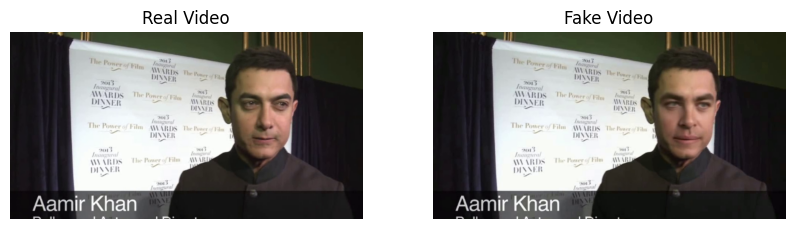

In [1]:
import cv2
import matplotlib.pyplot as plt

# Correct paths for the real and fake videos
real_video_path = '/kaggle/input/celeb-df-v2/Celeb-real/id0_0008.mp4'
fake_video_path = '/kaggle/input/celeb-df-v2/Celeb-synthesis/id0_id16_0008.mp4'

def extract_one_frame(video_path, frame_number=100):
    """Extract one specific frame from the video and convert from BGR to RGB."""
    video_reader = cv2.VideoCapture(video_path)
    
    # Set the frame to extract (frame_number)
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    success, frame = video_reader.read()
    
    if success:
        # Convert from BGR (OpenCV default) to RGB (for matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Failed to extract frame from {video_path}")
        frame_rgb = None
    
    video_reader.release()
    return frame_rgb

# Function to visualize real and fake frames
def visualize_frames(real_frame, fake_frame):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display Real frame
    axes[0].imshow(real_frame)
    axes[0].set_title("Real Video")
    axes[0].axis("off")  # Hide axis

    # Display Fake frame
    axes[1].imshow(fake_frame)
    axes[1].set_title("Fake Video")
    axes[1].axis("off")  # Hide axis

    # Display the plot
    plt.show()

# Extract one frame from the real video
real_frame = extract_one_frame(real_video_path)

# Extract one frame from the fake video
fake_frame = extract_one_frame(fake_video_path)

# Visualize the frames if they were extracted successfully
if real_frame is not None and fake_frame is not None:
    visualize_frames(real_frame, fake_frame)
else:
    print("Frame extraction failed.")


In [2]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00


2024-11-24 03:01:01.419988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 03:01:01.420189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 03:01:01.612677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


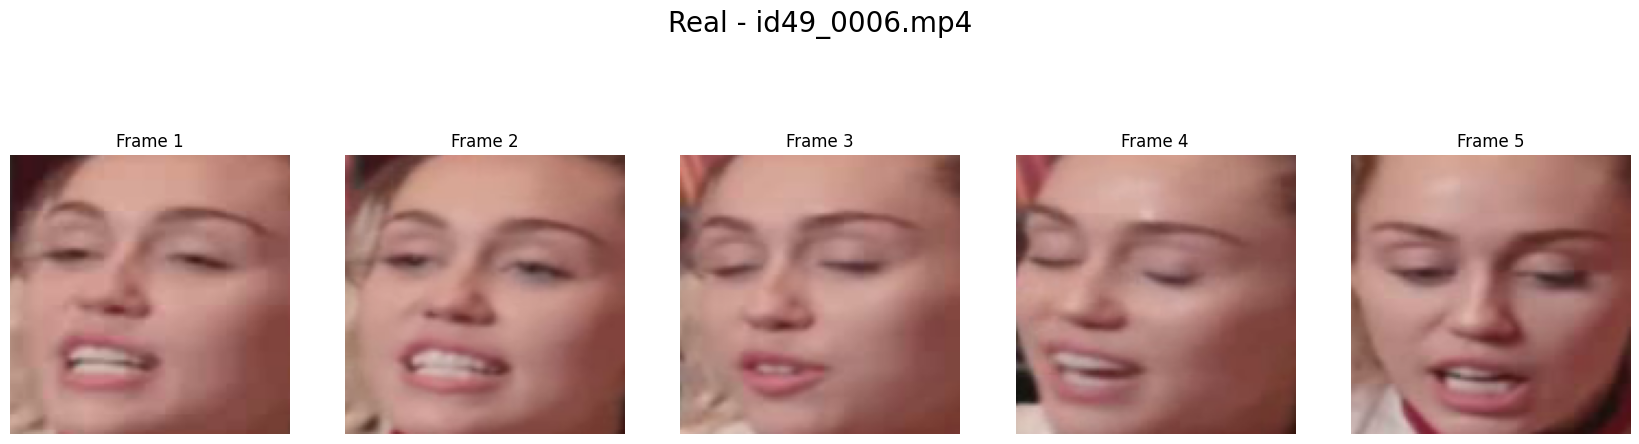

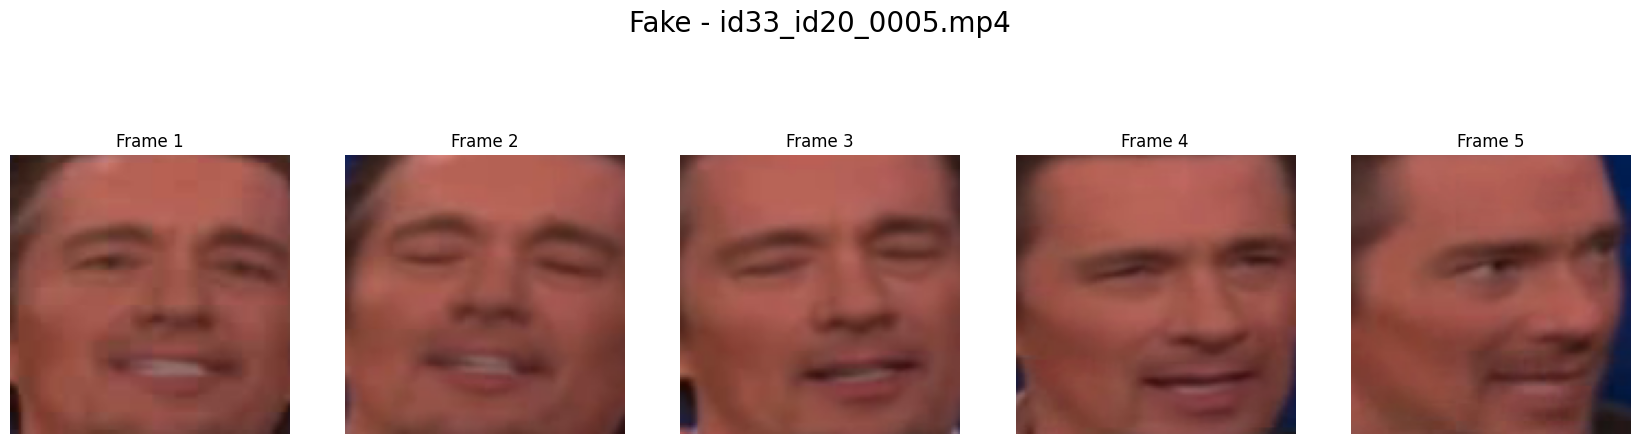

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 20
FRAME_SKIP = 2
CLASSES_LIST = ["Real", "Fake"]
DATASET_DIRS = {
    "Real": [
        '/kaggle/input/celeb-df-v2/Celeb-real',
        '/kaggle/input/celeb-df-v2/YouTube-real'
    ],
    "Fake": ['/kaggle/input/celeb-df-v2/Celeb-synthesis']
}

def frames_extraction_for_visualization(video_path, num_frames=5):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames_needed = num_frames * FRAME_SKIP
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(video_frames_count // total_frames_needed, 1)
    detector = MTCNN()

    for i in range(0, num_frames * FRAME_SKIP, FRAME_SKIP):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_step)
        success, frame = video_reader.read()
        if not success:
            break

        faces = detector.detect_faces(frame)
        if faces:
            x, y, width, height = faces[0]['box']
            frame = frame[y:y+height, x:x+width]

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames_list.append(resized_frame)

        if len(frames_list) == num_frames:
            break

    video_reader.release()
    return frames_list

def visualize_frames(frames, title):
    plt.figure(figsize=(18, 6))  # Adjusted figure size for better spacing
    num_frames = len(frames)
    for i, frame in enumerate(frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}", fontsize=12)  # Label each frame
        plt.axis('off')
    
    plt.suptitle(title, fontsize=20, y=0.95)  # Adjusted y-position for the title
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)  # Adjust margins
    plt.show()

# Function to visualize frames from a video in each class
def visualize_sample_frames_from_each_class():
    for class_name in CLASSES_LIST:
        for dir_path in DATASET_DIRS[class_name]:
            files_list = os.listdir(dir_path)
            video_file = os.path.join(dir_path, files_list[0])  # Pick the first video in the directory

            frames = frames_extraction_for_visualization(video_file, num_frames=5)
            visualize_frames(frames, f"{class_name} - {os.path.basename(video_file)}")
            break  # Only visualize one video per class

# Visualize sample frames from each class
visualize_sample_frames_from_each_class()


In [4]:
import os
import cv2
import numpy as np
import pickle
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from mtcnn import MTCNN

SEED_CONSTANT = 27
np.random.seed(SEED_CONSTANT)
random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Real", "Fake"]
DATASET_DIRS = {
    "Real": [
        '/kaggle/input/celeb-df-v2/Celeb-real',
        '/kaggle/input/celeb-df-v2/YouTube-real'
    ],
    "Fake": ['/kaggle/input/celeb-df-v2/Celeb-synthesis']
}
SAVE_DIR = '/kaggle/working'

os.makedirs(SAVE_DIR, exist_ok=True)

def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame step to get SEQUENCE_LENGTH frames
    frame_step = max(video_frames_count // SEQUENCE_LENGTH, 1)
    detector = MTCNN()

    for i in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_step)
        success, frame = video_reader.read()
        if not success:
            break

        faces = detector.detect_faces(frame)
        if faces:
            x, y, width, height = faces[0]['box']
            frame = frame[y:y+height, x:x+width]

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        for dir_path in DATASET_DIRS[class_name]:
            files_list = os.listdir(dir_path)
            if 'YouTube-real' in dir_path:
                selected_files = random.sample(files_list, 20)
            elif 'Celeb-real' in dir_path:
                selected_files = random.sample(files_list, 281)
            else:  # Celeb-synthesis
                selected_files = random.sample(files_list, 300)

            for file_name in selected_files:
                video_file_path = os.path.join(dir_path, file_name)
                frames = frames_extraction(video_file_path)

                if len(frames) == SEQUENCE_LENGTH:
                    features.append(frames)
                    labels.append(1 if class_name == "Fake" else 0)
                    video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels, dtype=np.float32)
    return features, labels, video_files_paths

# create dataset
features, labels, video_files_paths = create_dataset()

# split 8-2
X_train, X_val, y_train, y_val, video_train, video_val = train_test_split(
    features, labels, video_files_paths, test_size=0.2, random_state=SEED_CONSTANT, stratify=labels)

# save train
train_features_filename = os.path.join(SAVE_DIR, 'train_features_600videos_128pxl_20seq.npy')
train_labels_filename = os.path.join(SAVE_DIR, 'train_labels_600videos_128pxl_20seq.npy')
train_video_files_paths_filename = os.path.join(SAVE_DIR, 'train_video_files_600videos_128pxl_20seq.pkl')

np.save(train_features_filename, X_train)
np.save(train_labels_filename, y_train)

with open(train_video_files_paths_filename, 'wb') as f:
    pickle.dump(video_train, f)

print("Training features saved to:", train_features_filename)
print("Training labels saved to:", train_labels_filename)
print("Training video file paths saved to:", train_video_files_paths_filename)

# save val
val_features_filename = os.path.join(SAVE_DIR, 'val_features_600videos_128pxl_20seq.npy')
val_labels_filename = os.path.join(SAVE_DIR, 'val_labels_600videos_128pxl_20seq.npy')
val_video_files_paths_filename = os.path.join(SAVE_DIR, 'val_video_files_600videos_128pxl_20seq.pkl')

np.save(val_features_filename, X_val)
np.save(val_labels_filename, y_val)

with open(val_video_files_paths_filename, 'wb') as f:
    pickle.dump(video_val, f)

print("Validation features saved to:", val_features_filename)
print("Validation labels saved to:", val_labels_filename)
print("Validation video file paths saved to:", val_video_files_paths_filename)

Extracting Data of Class: Real
Extracting Data of Class: Fake
Training features saved to: /kaggle/working/train_features_600videos_128pxl_20seq.npy
Training labels saved to: /kaggle/working/train_labels_600videos_128pxl_20seq.npy
Training video file paths saved to: /kaggle/working/train_video_files_600videos_128pxl_20seq.pkl
Validation features saved to: /kaggle/working/val_features_600videos_128pxl_20seq.npy
Validation labels saved to: /kaggle/working/val_labels_600videos_128pxl_20seq.npy
Validation video file paths saved to: /kaggle/working/val_video_files_600videos_128pxl_20seq.pkl


In [5]:
import os
import random
import shutil
import pickle

DATASET_DIRS = {
    "Real": [
        '/kaggle/input/celeb-df-v2/Celeb-real',
        '/kaggle/input/celeb-df-v2/YouTube-real'
    ],
    "Fake": ['/kaggle/input/celeb-df-v2/Celeb-synthesis']
}
EXPORT_DIR = '/kaggle/working/test_videos'
os.makedirs(EXPORT_DIR, exist_ok=True)

def export_test_videos():
    all_videos = {"Real": [], "Fake": []}
    selected_videos = set()

    # Collect all video paths
    for class_name, dirs in DATASET_DIRS.items():
        for dir_path in dirs:
            videos = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.mp4')]
            all_videos[class_name].extend(videos)

    # Read the selected videos from the pickle files
    with open('/kaggle/working/train_video_files_600videos_128pxl_20seq.pkl', 'rb') as f:
        selected_videos.update(pickle.load(f))
    with open('/kaggle/working/val_video_files_600videos_128pxl_20seq.pkl', 'rb') as f:
        selected_videos.update(pickle.load(f))

    # Filter out the selected videos for each class
    unselected_videos = {
        "Real": [v for v in all_videos["Real"] if v not in selected_videos],
        "Fake": [v for v in all_videos["Fake"] if v not in selected_videos]
    }

    # Randomly select 10 videos for each class
    test_videos = {
        "Real": random.sample(unselected_videos["Real"], 30),
        "Fake": random.sample(unselected_videos["Fake"], 30)
    }

    # Copy the selected test videos to the export directory
    for class_name, videos in test_videos.items():
        class_dir = os.path.join(EXPORT_DIR, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for video_path in videos:
            video_name = os.path.basename(video_path)
            dest_path = os.path.join(class_dir, video_name)
            shutil.copy2(video_path, dest_path)
            print(f"Exported {class_name}: {video_name}")

    print(f"Exported 10 test videos for each class to: {EXPORT_DIR}")

    # Save the list of exported test videos
    test_videos_list = {
        "Real": [os.path.basename(v) for v in test_videos["Real"]],
        "Fake": [os.path.basename(v) for v in test_videos["Fake"]]
    }
    with open(os.path.join(EXPORT_DIR, 'test_videos_list.pkl'), 'wb') as f:
        pickle.dump(test_videos_list, f)
    print("Saved list of exported test videos to: test_videos_list.pkl")

if __name__ == "__main__":
    export_test_videos()

Exported Real: id39_0005.mp4
Exported Real: id2_0005.mp4
Exported Real: 00168.mp4
Exported Real: 00067.mp4
Exported Real: 00010.mp4
Exported Real: 00164.mp4
Exported Real: 00283.mp4
Exported Real: id20_0006.mp4
Exported Real: 00045.mp4
Exported Real: id11_0003.mp4
Exported Real: id31_0000.mp4
Exported Real: 00026.mp4
Exported Real: 00247.mp4
Exported Real: id55_0008.mp4
Exported Real: 00065.mp4
Exported Real: id35_0008.mp4
Exported Real: 00059.mp4
Exported Real: id16_0007.mp4
Exported Real: 00151.mp4
Exported Real: 00160.mp4
Exported Real: 00076.mp4
Exported Real: 00255.mp4
Exported Real: id60_0009.mp4
Exported Real: id45_0003.mp4
Exported Real: 00057.mp4
Exported Real: id29_0008.mp4
Exported Real: 00052.mp4
Exported Real: 00041.mp4
Exported Real: 00282.mp4
Exported Real: 00174.mp4
Exported Fake: id26_id37_0004.mp4
Exported Fake: id56_id51_0001.mp4
Exported Fake: id29_id33_0003.mp4
Exported Fake: id28_id33_0007.mp4
Exported Fake: id21_id38_0004.mp4
Exported Fake: id50_id55_0001.mp4
Exp